In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix  

In [1]:
class Abalone():
    def __init__(self, sex, length, diameter, height, wholeHeight, shuckedWeight, visceraWeight, shellWeight, rings):
        self.sex=sex
        self.length=length
        self.diameter=diameter
        self.height=height
        self.wholeHeight=wholeHeight
        self.shuckedWeight=shuckedWeight
        self.visceraWeight=visceraWeight
        self.shellWeight=shellWeight
        self.rings=rings
        
    def __repr__(self):
        str = "Sex:{sex}\nLength:{length}\nDiameter:{diameter}\nHeigth:{height}\n"\
        "WholeHeight:{wholeHeight}\nShuckedWeight:{shuckedWeight}\n"\
        "VisceraWeight:{visceraWeight}\nShellWeight:{shellWeight}\nRings:{rings}\n"
        str = str.format(sex=self.sex, length=self.length, diameter = self.diameter,
                        height=self.height,wholeHeight=self.wholeHeight,shuckedWeight=self.shuckedWeight,
                         visceraWeight=self.visceraWeight, shellWeight=self.shellWeight, rings=self.rings)
        return str
            

In [26]:
def readAbaloneData():
    abalones = []
    try:
        with open("data/abalone.data","r") as f:
            for line in f.read().splitlines():
                sd = line.split(",") # split data
                abalones.append(Abalone(sd[0],sd[1],sd[2],sd[3],sd[4],sd[5],sd[6],sd[7],sd[8]))
    except Exception as e:
        print("Exception:",str(e))
        abalones = []
    return abalones
abalones = readAbaloneData()
print(abalones[0])

Sex:Sex
Length:Length
Diameter:Diaemeter
Heigth:Height
WholeHeight:WholeHeight
ShuckedWeight:ShuckedWeight
VisceraWeight:VisceraWeight
ShellWeight:ShellWeight
Rings:Rings



In [211]:
# save as pandas data frame
df = pd.read_csv('data/abalone.data')

In [212]:
df.dtypes

Sex               object
Length           float64
Diaemeter        float64
Height           float64
WholeHeight      float64
ShuckedWeight    float64
VisceraWeight    float64
ShellWeight      float64
Rings              int64
dtype: object

In [213]:
df.describe()

,Length,Diaemeter,Height,WholeHeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


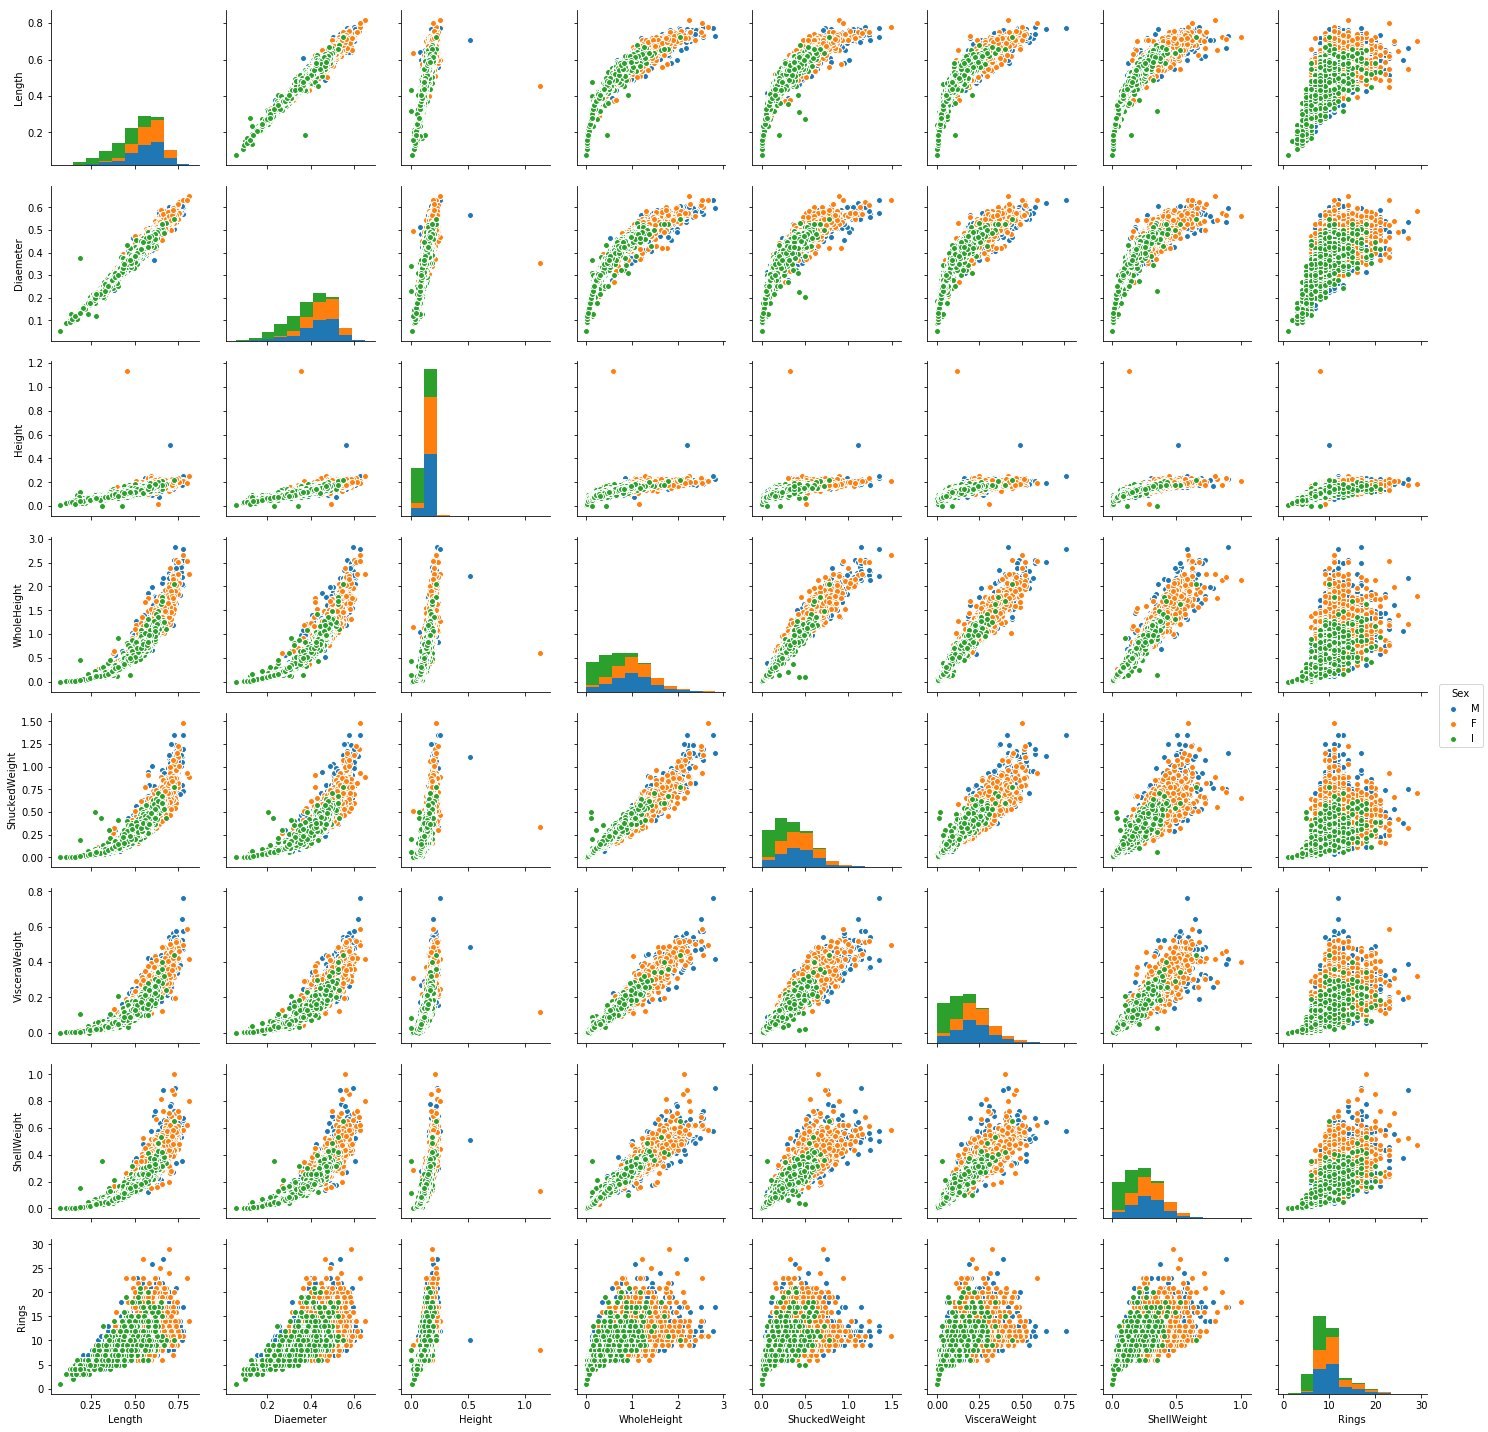

In [204]:
sns.pairplot(df, hue='Sex')

In [205]:
def build_dt(X, y, attribute_types, options):
    """
    X: the matrix of features/attributes for training data
    y: The vector containing the class labels for each sample in the row of X
    attribute_types: The vector containing (1:integer/real) or (2: categorical) indicating the type of each attributes
    options: any options you might want to pass to decision tree
    RETURN: a decision tree of the structure of your choice
    """
    dtc = DecisionTreeClassifier()
    dtc.fit(X, y)
    return dtc

In [206]:
'''
def cat2int(column):
    vals = list(set(column))
    for i, string in enumerate(column):
        column[i] = int(vals.index(string))
    return column

cat2int(df['Sex'].values)
df[['Sex']].apply(pd.to_numeric)
None
'''

In [207]:
def predict_dt(dt, X, options):
    """
    dt: decision tree modeled by 'build_dt function
    X: is the matrix of features/attributes for the test data
    options: any options you might want to pass to decision tree
    """
    return dt.predict(X)

In [214]:
all_inputs = df[['Length','Diaemeter','Height','WholeHeight','ShuckedWeight','VisceraWeight','ShellWeight', 'Rings']].values
all_classes = df['Sex'].values
(train_inputs, test_inputs, train_classes, test_classes) = train_test_split(all_inputs, all_classes, train_size=0.7, test_size=0.3, random_state=1)

In [215]:
dtc = build_dt(train_inputs, train_classes, None, None)

In [216]:
test_pred = predict_dt(dtc, test_inputs, None)

In [217]:
print(confusion_matrix(test_classes, test_pred))  
print(classification_report(test_classes, test_pred))  

[[145  61 188]
 [ 54 263  74]
 [175  92 202]]
             precision    recall  f1-score   support

          F       0.39      0.37      0.38       394
          I       0.63      0.67      0.65       391
          M       0.44      0.43      0.43       469

avg / total       0.48      0.49      0.48      1254

